In [ ]:
import random
import torch
from transformers import LlamaForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from peft import PeftModel
from matplotlib.patches import Rectangle

dev = torch.device('cuda:0')

random.seed(42)
torch.random.manual_seed(42)

tokenizer = AutoTokenizer.from_pretrained("model/llama3")
model = LlamaForCausalLM.from_pretrained("model/llama3")
model.to(dev)

cmap = sns.color_palette("Blues", as_cmap=True)

dataset = 'monotonic-m3-c2'
original_X = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'][:3]

example = open(f'data/{dataset}/val.txt', 'r').readlines()[8].strip()

model_inputs = tokenizer(example.strip(), return_tensors="pt")["input_ids"].to(dev)

output = model.forward(model_inputs, output_attentions=True)

finetuned_model = PeftModel.from_pretrained(model, f"model/llama3_finetuned/{dataset}-32-0/checkpoint-200")
finetuned_model.eval()
finetuned_model.to(dev)

finetuned_output = finetuned_model.forward(model_inputs, output_attentions=True)

tokens = tokenizer.convert_ids_to_tokens(model_inputs[0])


/raid/speech/harshavardhan/miniconda3/envs/llama-icll/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


/tmp/ipykernel_3369580/2771624145.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0, 0, 0])  # Leave space for the xlabel
/tmp/ipykernel_3369580/2771624145.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.0, 0, 0, 0])  # Leave space for the xlabel


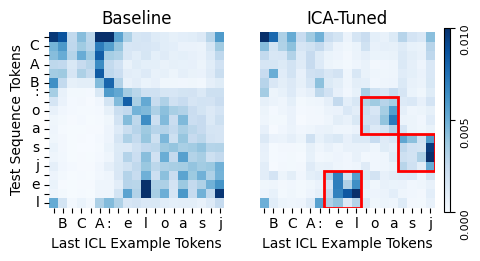

In [2]:
def plot_attention_side_by_side(attention1, attention2, layer, tokens, highlight_blocks=None):
    tokens = [t.replace('Ġ', '').replace('!', '') for t in tokens]
    
    # Process the attention matrices
    attention_matrix1 = torch.mean(attention1[layer][0], dim=0).detach().cpu().numpy()
    attention_matrix2 = torch.mean(attention2[layer][0], dim=0).detach().cpu().numpy()
    
    x = 15 * 19
    xticks = list(np.arange(0, 19, 1) + x - 19)
    yticks = list(np.arange(0, 19, 1) + x)
    
    xticklabels = [f'{tokens[i]}' for i in xticks]
    yticklabels = [f'{tokens[i]}' for i in yticks]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), 
                              gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]})
    vmin, vmax = 0, 0.010  # Set limits for the color scale

    # Plot the first heatmap
    sns.heatmap(
        attention_matrix1[yticks, :][:, xticks],
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        square=True,
        cmap="Blues",
        cbar=False,  # Disable colorbar here
        vmin=vmin,
        vmax=vmax,
        ax=axes[0]
    )
    axes[0].set_title(f'Baseline', fontsize=12)
    axes[0].set_ylabel('Test Sequence Tokens', fontsize=10)
    axes[0].set_xlabel('Last ICL Example Tokens', fontsize=10)
    axes[0].tick_params(axis='x', labelsize=10)
    axes[0].tick_params(axis='y', labelsize=10, rotation=0)

    # Plot the second heatmap
    sns.heatmap(
        attention_matrix2[yticks, :][:, xticks],
        xticklabels=xticklabels,
        yticklabels=False,  # Remove yticklabels for the second plot
        square=True,
        cmap="Blues",
        cbar=False,  # Add colorbar here
        cbar_kws={"shrink": 0.7, "orientation": "vertical"},  # Horizontal colorbar
        vmin=vmin,
        vmax=vmax,
        ax=axes[1]
    )
    axes[1].set_title(f'ICA-Tuned', fontsize=12)
    axes[1].set_ylabel('', fontsize=10)  # No Y-axis label for the second plot
    axes[1].set_xlabel('Last ICL Example Tokens', fontsize=10)
    axes[1].tick_params(axis='x', labelsize=10)
    axes[1].tick_params(axis='y', labelsize=10)

    # Add a common colorbar below both heatmaps
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax)),
        ax=axes,
        location="right",
        aspect=30,  # Adjust length of the colorbar
        shrink=0.8,
        pad=0.02  # Padding between the plots and the colorbar
    )
    cbar.ax.tick_params(labelsize=8, rotation=90)
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])

    # Highlight blocks on the second heatmap if specified
    if highlight_blocks:
        for block in highlight_blocks:
            y_start, y_end, x_start, x_end = block
            rect = Rectangle(
                (x_start, y_start),  # Bottom-left corner (x, y)
                x_end - x_start,  # Width
                y_end - y_start,  # Height
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            axes[1].add_patch(rect)

    # Adjust layout for consistent appearance
    plt.tight_layout(rect=[0.0, 0, 0, 0])  # Leave space for the xlabel
    # plt.show()

    plt.savefig(f'figures/attention_layer_{layer+1}.png', dpi=300, bbox_inches='tight')

# Example usage
highlight_blocks = [
    (7, 11, 11, 15),
    (11, 15, 15, 19),
    (15, 19, 7, 11),
]
plot_attention_side_by_side(output['attentions'], finetuned_output['attentions'], 17, tokens, highlight_blocks=highlight_blocks)


/tmp/ipykernel_3369580/814763.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0, 0, 0])  # Leave space for the xlabel
/tmp/ipykernel_3369580/814763.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0.0, 0, 0, 0])  # Leave space for the xlabel


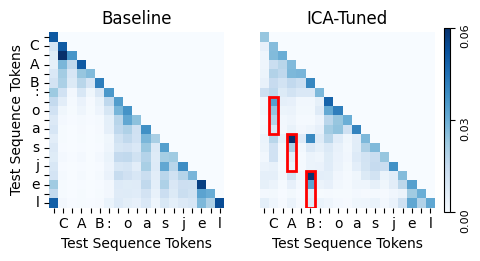

In [3]:
def plot_attention_side_by_side(attention1, attention2, layer, tokens, highlight_blocks=None):
    tokens = [t.replace('Ġ', '').replace('!', '') for t in tokens]
    
    # Process the attention matrices
    attention_matrix1 = torch.mean(attention1[layer][0], dim=0).detach().cpu().numpy()
    attention_matrix2 = torch.mean(attention2[layer][0], dim=0).detach().cpu().numpy()
    
    x = 15 * 19
    xticks = list(np.arange(0, 19, 1) + x)
    yticks = list(np.arange(0, 19, 1) + x)
    
    xticklabels = [f'{tokens[i]}' for i in xticks]
    yticklabels = [f'{tokens[i]}' for i in yticks]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), 
                              gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]})
    vmin, vmax = 0, 0.06  # Set limits for the color scale

    # Plot the first heatmap
    sns.heatmap(
        attention_matrix1[yticks, :][:, xticks],
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        square=True,
        cmap="Blues",
        cbar=False,  # Disable colorbar here
        vmin=vmin,
        vmax=vmax,
        ax=axes[0]
    )
    axes[0].set_title(f'Baseline', fontsize=12)
    axes[0].set_ylabel('Test Sequence Tokens', fontsize=10)
    axes[0].set_xlabel('Test Sequence Tokens', fontsize=10)
    axes[0].tick_params(axis='x', labelsize=10)
    axes[0].tick_params(axis='y', labelsize=10, rotation=0)

    # Plot the second heatmap
    sns.heatmap(
        attention_matrix2[yticks, :][:, xticks],
        xticklabels=xticklabels,
        yticklabels=False,  # Remove yticklabels for the second plot
        square=True,
        cmap="Blues",
        cbar=False,  # Add colorbar here
        cbar_kws={"shrink": 0.7, "orientation": "vertical"},  # Horizontal colorbar
        vmin=vmin,
        vmax=vmax,
        ax=axes[1]
    )
    axes[1].set_title(f'ICA-Tuned', fontsize=12)
    axes[1].set_ylabel('', fontsize=10)  # No Y-axis label for the second plot
    axes[1].set_xlabel('Test Sequence Tokens', fontsize=10)
    axes[1].tick_params(axis='x', labelsize=10)
    axes[1].tick_params(axis='y', labelsize=10)

    # Add a common colorbar below both heatmaps
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax)),
        ax=axes,
        location="right",
        aspect=30,  # Adjust length of the colorbar
        shrink=0.8,
        pad=0.02  # Padding between the plots and the colorbar
    )
    cbar.ax.tick_params(labelsize=8, rotation=90)
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])

    # Highlight blocks on the second heatmap if specified
    if highlight_blocks:
        for block in highlight_blocks:
            y_start, y_end, x_start, x_end = block
            rect = Rectangle(
                (x_start, y_start),  # Bottom-left corner (x, y)
                x_end - x_start,  # Width
                y_end - y_start,  # Height
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            axes[1].add_patch(rect)

    # Adjust layout for consistent appearance
    plt.tight_layout(rect=[0.0, 0, 0, 0])  # Leave space for the xlabel
    # plt.show()

    plt.savefig(f'figures/attention_layer_{layer+1}.png', dpi=300, bbox_inches='tight')
    

highlight_blocks = [
    (7, 11, 1, 2),  
    (11, 15, 3, 4),  
    (15, 19, 5, 6),  
]
plot_attention_side_by_side(output['attentions'], finetuned_output['attentions'], 13, tokens, highlight_blocks=highlight_blocks)
